In [1]:
import glob
import seaborn as sns
import pandas as pd
import pybedtools
from matplotlib import pyplot as plt
import pyBigWig
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42
import PyComplexHeatmap as pch
from PyComplexHeatmap import *

In [2]:
dmr_dir = '/home/qzeng/project/aging/230907-recall-dmr/Merge_DMR/mC_FILTER_DMR_BED'
all_mc_cts = [path.split('/')[-1].split('.Hypo')[0] for path in glob.glob(f"{dmr_dir}/*.Hypo.aDMR.bed")]
all_atac_cts = [path.split('/')[-1].split('_18mo')[0].split('Female_')[-1] for path in glob.glob(f"/ceph/gale-1/qzeng/AmbData/Luisa/female_atac/Female_*_18mo_merge.bw")]
shared_cts = list(set(all_mc_cts) & set(all_atac_cts))

In [3]:
plot_celltypes = ['CA1-ProS_Glut','L23_IT_ENT_Glut', 'L23_IT_PPP_Glut','L5_IT_CTX_Glut', 'DG_Glut',
                  'L6_IT_CTX_Glut', 'L5_ET_CTX_Glut', 'CA3_Glut', 'ENTmv-PA-COAp_Glut', 'L45_IT_CTX_Glut', 'LA-BLA-BMA-PA_Glut',
                 'Astro-NT_NN','Astro-TE_NN', 'Microglia_NN','Vip_Gaba', 'Lamp5_Gaba','Sst_Gaba','Sst_Chodl_Gaba', 'CEA-BST_Gaba',
                  'MB-MY_Tph2_Glut-Sero','STR_D1_Sema5a_Gaba','STR_D1_Gaba',  'NP_SUB_Glut','L5_NP_CTX_Glut','L2_IT_PPP-APr_Glut']

In [4]:
# plot_celltypes = ['CA1-ProS_Glut','L23_IT_ENT_Glut', 'L23_IT_PPP_Glut','L5_IT_CTX_Glut', 'DG_Glut',
#                   'L6_IT_CTX_Glut', 'L5_ET_CTX_Glut', 'CA3_Glut', 'ENTmv-PA-COAp_Glut', 'L45_IT_CTX_Glut', 'LA-BLA-BMA-PA_Glut',
#                  ]

## get overlap dmr region

In [5]:
exmaple_hotspolt = 'chr13-68173500-68174000'
_chr, hotspot_start, hotspot_end = exmaple_hotspolt.split('-')
hotspot_start, hotspot_end = int(hotspot_start), int(hotspot_end)
hotspot_start, hotspot_end

(68173500, 68174000)

In [6]:
dmr_dir = '/home/qzeng/project/aging/230907-recall-dmr/Merge_DMR/mC_FILTER_DMR_BED'

all_df = []
hotspot = pybedtools.BedTool(f"{_chr} {hotspot_start} {hotspot_end}", from_string=True)
for ct in plot_celltypes:
    dmr_path = f"{dmr_dir}/{ct}.Hypo.aDMR.bed"
    dmr_bed = pybedtools.BedTool(dmr_path)
    intersected = dmr_bed.intersect(hotspot, wa=True)
    tmpdf = intersected.to_dataframe(names=['dmr_id', '8wk', '9mo', '18mo']) 
    tmpdf['celltype'] = ct
    all_df.append(tmpdf)

all_df = pd.concat(all_df)
all_df = all_df.set_index('dmr_id')
all_df.head()

,8wk,9mo,18mo,celltype
dmr_id,,,,
chr13-68173456-68173942,0.80,0.61,0.22,CA1-ProS_Glut
chr13-68173584-68174051,0.82,0.48,0.28,L23_IT_ENT_Glut
chr13-68173584-68173714,0.57,0.41,0.26,L23_IT_PPP_Glut
chr13-68173767-68173780,0.68,0.62,0.44,L23_IT_PPP_Glut
chr13-68173919-68173939,0.77,0.71,0.53,L23_IT_PPP_Glut


## get mc info from bigwig

In [7]:
_gender = 'male'
bigwig_dir = f'/ceph/gale-1/qzeng/AmbData/CellType_Allc/M.CellType.Age'
mc_all_df = []

for ct in plot_celltypes:
    try:
        dmr_id = all_df[all_df['celltype']== ct].index[0]
    except IndexError:
        dmr_id = exmaple_hotspolt
    
    _chr, start, end = dmr_id.split('-')
    start, end = int(start), int(end)
    
    total_counts_df = {}
    for age in ['8wk','9mo','18mo']:
        bigwig_path = f"{bigwig_dir}/{ct}.{age}/{ct}.{age}.CGN-both.frac.bw"
        bw = pyBigWig.open(bigwig_path)
        total_counts = bw.stats(_chr, start, end, type="mean")
        total_counts_df[age] = total_counts
    total_counts_df = pd.DataFrame(total_counts_df)
    total_counts_df.index = [ct]
    mc_all_df.append(total_counts_df)

male_mc = pd.concat(mc_all_df)
male_mc.columns = [f"{_gender}.2mo",f"{_gender}.9mo",f"{_gender}.18mo"]
male_mc.head()

,male.2mo,male.9mo,male.18mo
CA1-ProS_Glut,0.803165,0.665307,0.295900
L23_IT_ENT_Glut,0.816773,0.516423,0.306860
L23_IT_PPP_Glut,0.660426,0.477904,0.415435
L5_IT_CTX_Glut,0.836029,0.273780,0.397662
DG_Glut,0.841183,0.588116,0.360984


In [8]:
_gender = 'female'
bigwig_dir = f'/ceph/gale-1/qzeng/AmbData/CellType_Allc/F.CellType.Age'
mc_all_df = []

for ct in plot_celltypes:
    try:
        dmr_id = all_df[all_df['celltype']== ct].index[0]
    except IndexError:
        dmr_id = exmaple_hotspolt
    
    _chr, start, end = dmr_id.split('-')
    start, end = int(start), int(end)
    
    total_counts_df = {}
    for age in ['8wk','9mo','18mo']:
        bigwig_path = f"{bigwig_dir}/{ct}.{age}/{ct}.{age}.CGN-both.frac.bw"
        bw = pyBigWig.open(bigwig_path)
        total_counts = bw.stats(_chr, start, end, type="mean")
        total_counts_df[age] = total_counts
    total_counts_df = pd.DataFrame(total_counts_df)
    total_counts_df.index = [ct]
    mc_all_df.append(total_counts_df)

female_mc = pd.concat(mc_all_df)
female_mc.columns = [f"{_gender}.2mo",f"{_gender}.9mo",f"{_gender}.18mo"]
female_mc.head()

,female.2mo,female.9mo,female.18mo
CA1-ProS_Glut,0.780892,0.525568,0.121395
L23_IT_ENT_Glut,0.829085,0.463873,0.278972
L23_IT_PPP_Glut,0.562967,0.384804,0.113255
L5_IT_CTX_Glut,0.861681,0.273697,0.135269
DG_Glut,0.786408,0.436503,0.282031


In [9]:
mc_all_to_plot = pd.concat([male_mc, female_mc], axis = 1)

## check mch

In [10]:
_gender = 'male'
bigwig_dir = f'/ceph/gale-1/qzeng/AmbData/CellType_Allc/M.CellType.Age'
mc_all_df = []

for ct in plot_celltypes:
    try:
        dmr_id = all_df[all_df['celltype']== ct].index[0]
    except IndexError:
        dmr_id = exmaple_hotspolt
    
    _chr, start, end = dmr_id.split('-')
    start, end = int(start), int(end)
    slop = 100
    start, end = start + slop, end + slop
    
    total_counts_df = {}
    for age in ['8wk','9mo','18mo']:
        bigwig_path = f"{bigwig_dir}/{ct}.{age}/{ct}.{age}.CHN-both.frac.bw"
        bw = pyBigWig.open(bigwig_path)
        total_counts = bw.stats(_chr, start, end, type="mean")
        total_counts_df[age] = total_counts
    total_counts_df = pd.DataFrame(total_counts_df)
    total_counts_df.index = [ct]
    mc_all_df.append(total_counts_df)

male_mc = pd.concat(mc_all_df)
male_mc.columns = [f"{_gender}.2mo",f"{_gender}.9mo",f"{_gender}.18mo"]
#male_mc = male_mc.div(male_mc.sum(axis = 1), axis = 0)
male_mc.head()

,male.2mo,male.9mo,male.18mo
CA1-ProS_Glut,0.004658,0.011829,0.006471
L23_IT_ENT_Glut,0.006479,0.013527,0.006732
L23_IT_PPP_Glut,0.007384,0.009462,0.005425
L5_IT_CTX_Glut,0.007072,0.004876,0.009935
DG_Glut,0.005807,0.006901,0.005422


In [11]:
_gender = 'female'
bigwig_dir = f'/ceph/gale-1/qzeng/AmbData/CellType_Allc/F.CellType.Age'
mc_all_df = []

for ct in plot_celltypes:
    try:
        dmr_id = all_df[all_df['celltype']== ct].index[0]
    except IndexError:
        dmr_id = exmaple_hotspolt
    
    _chr, start, end = dmr_id.split('-')
    start, end = int(start), int(end)
    slop = 100
    start, end = start + slop, end + slop
    
    total_counts_df = {}
    for age in ['8wk','9mo','18mo']:
        bigwig_path = f"{bigwig_dir}/{ct}.{age}/{ct}.{age}.CHN-both.frac.bw"
        bw = pyBigWig.open(bigwig_path)
        total_counts = bw.stats(_chr, start, end, type="mean")
        total_counts_df[age] = total_counts
    total_counts_df = pd.DataFrame(total_counts_df)
    total_counts_df.index = [ct]
    mc_all_df.append(total_counts_df)

female_mc = pd.concat(mc_all_df)
female_mc.columns = [f"{_gender}.2mo",f"{_gender}.9mo",f"{_gender}.18mo"]
#female_mc = female_mc.div(female_mc.sum(axis = 1), axis = 0)
female_mc.head()

,female.2mo,female.9mo,female.18mo
CA1-ProS_Glut,0.005828,0.006215,0.006079
L23_IT_ENT_Glut,0.007446,0.003794,0.005383
L23_IT_PPP_Glut,0.009614,0.013679,0.001732
L5_IT_CTX_Glut,0.004792,0.007361,0.010006
DG_Glut,0.006548,0.008054,0.005038


In [12]:
mch_all_to_plot = pd.concat([male_mc, female_mc], axis = 1)
mch_all_to_plot.head()

,male.2mo,male.9mo,male.18mo,female.2mo,female.9mo,female.18mo
CA1-ProS_Glut,0.004658,0.011829,0.006471,0.005828,0.006215,0.006079
L23_IT_ENT_Glut,0.006479,0.013527,0.006732,0.007446,0.003794,0.005383
L23_IT_PPP_Glut,0.007384,0.009462,0.005425,0.009614,0.013679,0.001732
L5_IT_CTX_Glut,0.007072,0.004876,0.009935,0.004792,0.007361,0.010006
DG_Glut,0.005807,0.006901,0.005422,0.006548,0.008054,0.005038


## check atac

In [13]:
mc_to_atac = {'CA1-ProS_Glut': 'CA1-ProS_Glut',
             'L5_IT_CTX_Glut': 'L5_IT_CTX_Glut',
             'DG_Glut': 'DG_Glut',
             'L6_IT_CTX_Glut': 'L6_IT_CTX_Glut',
             'L5_ET_CTX_Glut': 'L5_ET_CTX_Glut',
             'CA3_Glut': 'CA3_Glut',
             'L23_IT_PPP_Glut':'L2_IT_PPP-APr_Glut',
             'ENTmv-PA-COAp_Glut': 'ENTmv-PA-COAp_Glut',
             'L45_IT_CTX_Glut':'L5_IT_CTX_Glut',
             'LA-BLA-BMA-PA_Glut': 'LA-BLA-BMA-PA_Glut',
             'L23_IT_ENT_Glut': 'L2_3_IT_ENT_Glut',
             'L23_IT_PPP_Glut':'L2_3_IT_PPP_Glut',
              'Astro-NT_NN':'Astro-NT',
              'Astro-TE_NN':'Astro-TE',
              'STR_D1_Gaba':'STR_D12_Gaba'
             }

In [14]:
_gender = 'male'
bigwig_dir = f'/ceph/gale-1/qzeng/AmbData/Luisa/{_gender}_atac'
atac_all_df = []

for ct in plot_celltypes:
    try:
        atac_ct = mc_to_atac[ct]
    except KeyError:
        atac_ct =ct
    
    try:
        dmr_id = all_df[all_df['celltype']== ct].index[0]
    except IndexError:
        dmr_id = exmaple_hotspolt
    slop = 300
    _chr, start, end = dmr_id.split('-')
    start, end = int(start), int(end)
    start, end = start + slop, end + slop
    
    total_counts_df = {}
    for age in ['2mo','9mo','18mo']:
        bigwig_path = f"{bigwig_dir}/Male_{atac_ct}_{age}_merge.bw"
        bw = pyBigWig.open(bigwig_path)
        total_counts = bw.stats(_chr, start, end, type="sum")
        total_counts_df[age] = total_counts
    total_counts_df = pd.DataFrame(total_counts_df)
    total_counts_df.index = [ct]
    atac_all_df.append(total_counts_df)

male_atac = pd.concat(atac_all_df)

male_atac = male_atac.div(male_atac.sum(axis = 1), axis = 0) # normalized to 0-1
male_atac.columns = [f"{_gender}.2mo",f"{_gender}.9mo",f"{_gender}.18mo"]
male_atac.head()

,male.2mo,male.9mo,male.18mo
CA1-ProS_Glut,0.054659,0.205204,0.740136
L23_IT_ENT_Glut,0.049513,0.406007,0.544481
L23_IT_PPP_Glut,0.215396,0.247420,0.537183
L5_IT_CTX_Glut,0.048871,0.362198,0.588932
DG_Glut,0.023381,0.398898,0.577721


In [15]:
mc_to_atac = {'CA1-ProS_Glut': 'CA1-ProS_Glut',
             'L5_IT_CTX_Glut': 'L5_IT_CTX_Glut',
             'DG_Glut': 'DG_Glut',
             'L6_IT_CTX_Glut': 'L6_IT_CTX_Glut',
             'L5_ET_CTX_Glut': 'L5_ET_CTX_Glut',
             'CA3_Glut': 'CA3_Glut',
             'L23_IT_PPP_Glut':'L2_IT_PPP-APr_Glut',
             'ENTmv-PA-COAp_Glut': 'ENTmv-PA-COAp_Glut',
             'L45_IT_CTX_Glut':'L5_IT_CTX_Glut',
             'LA-BLA-BMA-PA_Glut': 'LA-BLA-BMA-PA_Glut',
             'L23_IT_ENT_Glut': 'L2_3_IT_ENT_Glut',
             'L23_IT_PPP_Glut':'L2_3_IT_PPP_Glut',
              'STR_D1_Gaba':'STR_D12_Gaba'
              # 'Astro-NT_NN':'Astro-NT',
              # 'Astro-TE_NN':'Astro-TE',
             }

In [16]:
_gender = 'female'
bigwig_dir = f'/ceph/gale-1/qzeng/AmbData/Luisa/{_gender}_atac'
atac_all_df = []

for ct in plot_celltypes:
    try:
        atac_ct = mc_to_atac[ct]
    except KeyError:
        atac_ct =ct
        
    try:
        dmr_id = all_df[all_df['celltype']== ct].index[0]
    except IndexError:
        dmr_id = exmaple_hotspolt
    slop = 300
    _chr, start, end = dmr_id.split('-')
    start, end = int(start), int(end)
    start, end = start + slop, end + slop
    
    total_counts_df = {}
    for age in ['2mo','9mo','18mo']:
        bigwig_path = f"{bigwig_dir}/Female_{atac_ct}_{age}_merge.bw"
        bw = pyBigWig.open(bigwig_path)
        total_counts = bw.stats(_chr, start, end, type="sum")
        total_counts_df[age] = total_counts
    total_counts_df = pd.DataFrame(total_counts_df)
    total_counts_df.index = [ct]
    atac_all_df.append(total_counts_df)

female_atac = pd.concat(atac_all_df)

female_atac = female_atac.div(female_atac.sum(axis = 1), axis = 0) # normalized to 0-1
female_atac.columns = [f"{_gender}.2mo",f"{_gender}.9mo",f"{_gender}.18mo"]
female_atac.head()

,female.2mo,female.9mo,female.18mo
CA1-ProS_Glut,0.019937,0.298070,0.681994
L23_IT_ENT_Glut,0.025189,0.286324,0.688487
L23_IT_PPP_Glut,0.140373,0.248277,0.611350
L5_IT_CTX_Glut,0.042835,0.419707,0.537458
DG_Glut,0.036831,0.366718,0.596451


In [17]:
atac_all_to_plot = pd.concat([male_atac, female_atac], axis = 1)
atac_all_to_plot.head()

,male.2mo,male.9mo,male.18mo,female.2mo,female.9mo,female.18mo
CA1-ProS_Glut,0.054659,0.205204,0.740136,0.019937,0.298070,0.681994
L23_IT_ENT_Glut,0.049513,0.406007,0.544481,0.025189,0.286324,0.688487
L23_IT_PPP_Glut,0.215396,0.247420,0.537183,0.140373,0.248277,0.611350
L5_IT_CTX_Glut,0.048871,0.362198,0.588932,0.042835,0.419707,0.537458
DG_Glut,0.023381,0.398898,0.577721,0.036831,0.366718,0.596451


## RNA

In [18]:
mc_to_atac = {'CA1-ProS_Glut': 'CA1-ProS_Glut',
             'L5_IT_CTX_Glut': 'L5_IT_CTX_Glut',
             'DG_Glut': 'DG_Glut',
             'L6_IT_CTX_Glut': 'L6_IT_CTX_Glut',
             'L5_ET_CTX_Glut': 'L5_ET_CTX_Glut',
             'CA3_Glut': 'CA3_Glut',
             'L23_IT_PPP_Glut':'L2_IT_PPP-APr_Glut',
             'ENTmv-PA-COAp_Glut': 'ENTmv-PA-COAp_Glut',
             'L45_IT_CTX_Glut':'L5_IT_CTX_Glut',
             'LA-BLA-BMA-PA_Glut': 'LA-BLA-BMA-PA_Glut',
             'L23_IT_ENT_Glut': 'L2_IT_ENT-po_Glut',
              'STR_D1_Gaba':'STR_D12_Gaba'
             }

In [19]:
_gender = 'female'
bigwig_dir = f'/ceph/gale-1/qzeng/AmbData/Luisa/{_gender}_rna'
atac_all_df = []

for ct in plot_celltypes:
    try:
        atac_ct = mc_to_atac[ct]
    except KeyError:
        atac_ct =ct
        
    try:
        dmr_id = all_df[all_df['celltype']== ct].index[0]
    except IndexError:
        dmr_id = exmaple_hotspolt
        
    slop = 500
    _chr, start, end = dmr_id.split('-')
    start, end = int(start), int(end)
    start, end = start-slop, end + slop
    
    total_counts_df = {}
    for age in ['2mo','9mo','18mo']:
        bigwig_path = f"{bigwig_dir}/Female_RNA_{atac_ct}_{age}_merge.bw"
        bw = pyBigWig.open(bigwig_path)
        total_counts = bw.stats(_chr, start, end, type="mean")
        total_counts_df[age] = total_counts
    total_counts_df = pd.DataFrame(total_counts_df)
    total_counts_df.index = [ct]
    atac_all_df.append(total_counts_df)

female_rna = pd.concat(atac_all_df)

female_rna = female_rna.div(female_rna.sum(axis = 1), axis = 0) # normalized to 0-1
female_rna.columns = [f"{_gender}.2mo",f"{_gender}.9mo",f"{_gender}.18mo"]
female_rna.head()

,female.2mo,female.9mo,female.18mo
CA1-ProS_Glut,0.044832,0.260470,0.694697
L23_IT_ENT_Glut,0.145220,0.367261,0.487519
L23_IT_PPP_Glut,NaN,NaN,NaN
L5_IT_CTX_Glut,0.024227,0.703893,0.271880
DG_Glut,0.015296,0.387238,0.597467


## plot

In [26]:
ct_order = ['CA1-ProS_Glut', 'CA3_Glut', 'DG_Glut', 'L23_IT_ENT_Glut','L23_IT_PPP_Glut','ENTmv-PA-COAp_Glut',
            'L45_IT_CTX_Glut', 'L5_ET_CTX_Glut','L5_IT_CTX_Glut', 'L6_IT_CTX_Glut', 'LA-BLA-BMA-PA_Glut',
             'Astro-NT_NN','Astro-TE_NN', 'Microglia_NN','Vip_Gaba', 'Lamp5_Gaba','Sst_Gaba','Sst_Chodl_Gaba', 'CEA-BST_Gaba',
                 'STR_D1_Sema5a_Gaba','STR_D1_Gaba',  'MB-MY_Tph2_Glut-Sero', 'NP_SUB_Glut','L5_NP_CTX_Glut','L2_IT_PPP-APr_Glut']

# plot_celltypes = ['CA1-ProS_Glut','L23_IT_ENT_Glut', 'L23_IT_PPP_Glut','L5_IT_CTX_Glut', 'DG_Glut',
#                   'L6_IT_CTX_Glut', 'L5_ET_CTX_Glut', 'CA3_Glut', 'ENTmv-PA-COAp_Glut', 'L45_IT_CTX_Glut', 'LA-BLA-BMA-PA_Glut',
#                  'Astro-NT_NN','Astro-TE_NN', 'Microglia_NN','Vip_Gaba', 'Lamp5_Gaba','Sst_Gaba','Sst_Chodl_Gaba', 'CEA-BST_Gaba',
#                   'MB-MY_Tph2_Glut-Sero','STR_D1_Sema5a_Gaba','STR_D1_Gaba',  'NP_SUB_Glut','L5_NP_CTX_Glut','L2_IT_PPP-APr_Glut']

In [27]:
column_order = ['male.2mo','female.2mo',  'male.9mo', 'female.9mo','male.18mo', 'female.18mo']

# ct_order = ['CA1-ProS_Glut', 'CA3_Glut', 'DG_Glut', 
#             'L23_IT_ENT_Glut','L23_IT_PPP_Glut','ENTmv-PA-COAp_Glut',
#             'L45_IT_CTX_Glut', 'L5_ET_CTX_Glut',
#             'L5_IT_CTX_Glut', 'L6_IT_CTX_Glut', 
#             'LA-BLA-BMA-PA_Glut',]

In [28]:
atac_all_to_plot = atac_all_to_plot[column_order].loc[ct_order]
mc_all_to_plot = mc_all_to_plot[column_order].loc[ct_order]
mch_all_to_plot = mch_all_to_plot[column_order].loc[ct_order]
female_rna = female_rna.fillna(0).loc[ct_order]

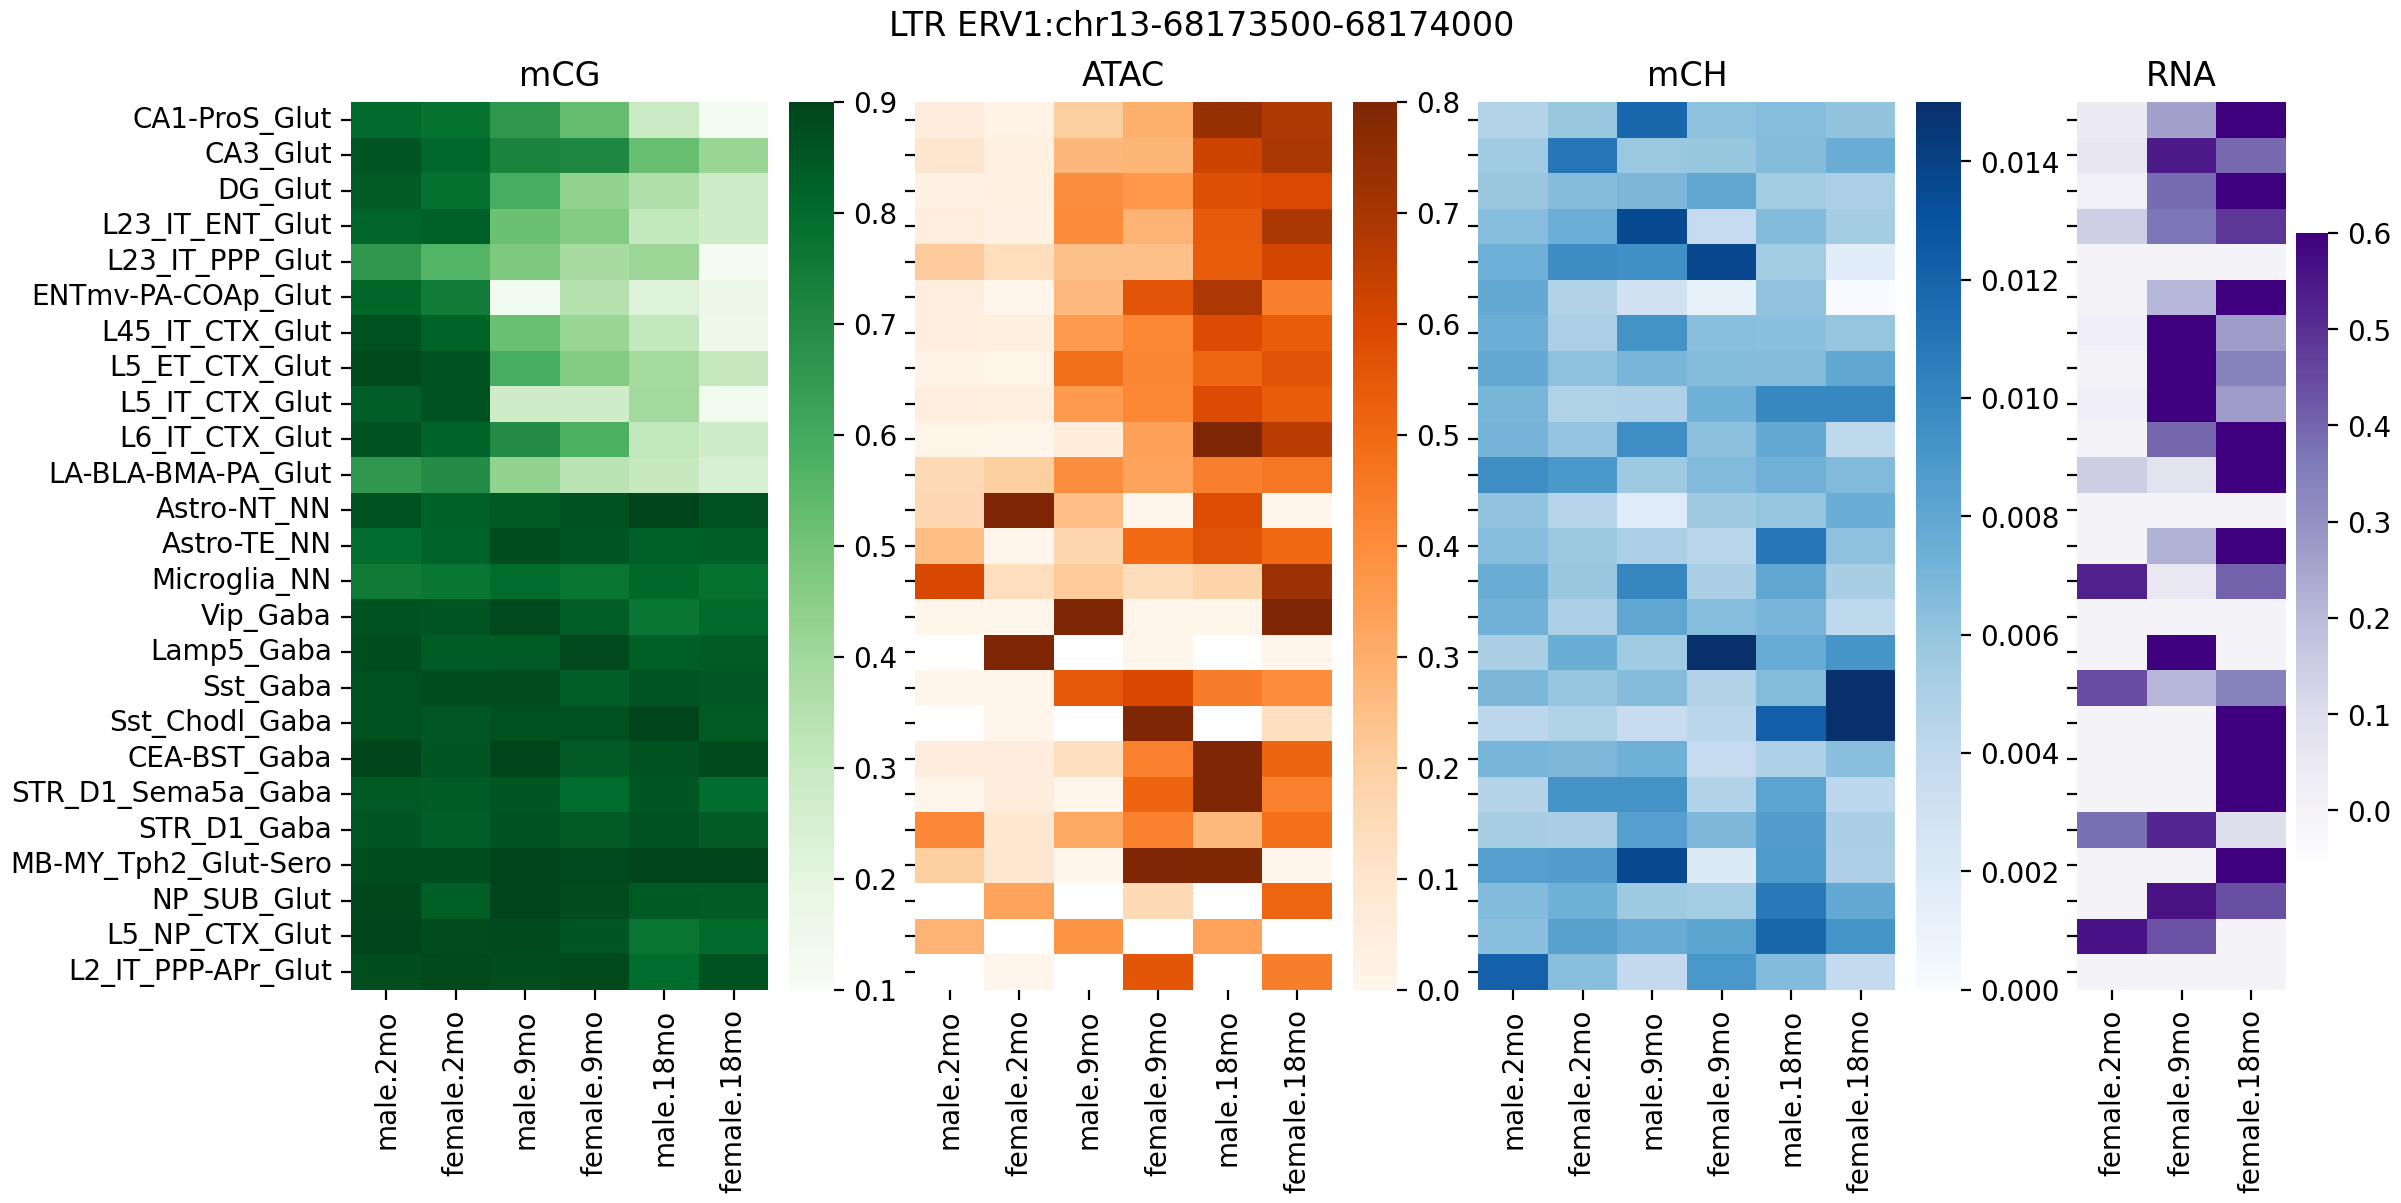

In [30]:
fig, axes = plt.subplots(figsize = (12,6), ncols = 4, dpi = 200, 
                         constrained_layout = True, sharey = True,
                         gridspec_kw={'width_ratios': [2, 2, 2, 1]})

ax = axes[0]
sns.heatmap(mc_all_to_plot, 
            xticklabels=True,
            yticklabels=True,
            ax=ax, rasterized = True,
            cmap = 'Greens',
            vmin = 0.1, vmax = 0.9)
ax.set_title("mCG")

ax = axes[1]
sns.heatmap(atac_all_to_plot, 
            xticklabels=True,
            yticklabels=True,
            ax=ax, rasterized = True,
            cmap = 'Oranges',
            vmin = 0, vmax = 0.8)
ax.set_title("ATAC")

ax = axes[2]
sns.heatmap(mch_all_to_plot, 
            xticklabels=True,
            yticklabels=True,
            ax=ax, rasterized = True,
            vmin = 0, vmax = 0.015,
            cmap = 'Blues',
            )
ax.set_title("mCH")
                                      
ax = axes[3]
sns.heatmap(female_rna, 
            xticklabels=True,
            yticklabels=True,
            ax=ax, rasterized = True,
            cmap = 'Purples',
            vmin = -0.05, vmax = 0.6
            )
ax.set_title("RNA")                                     
                            
plt.suptitle(f"LTR ERV1:{exmaple_hotspolt}")
fig.savefig(f"figure/Supp.LTR.Heatmap.pdf", bbox_inches  = 'tight')